In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
#os.environ['https_proxy']='http://192.168.0.6:10809/'
os.environ['TFDS_DATA_DIR']='E:\\Python\\tensorflow_datasets'
import numpy as np 
import tensorflow_datasets as tfds
%matplotlib inline 


In [2]:
#(ds_train_orig,ds_test_orig),ds_info = tfds.load('mnist',split=['train[:25%]', 'test[:25%]'],with_info=True)

(ds_train_orig,ds_test_orig),ds_info = tfds.load('mnist',split=['train', 'test'],with_info=True)

In [3]:
BATCH_SIZE=16

def opt_data(ds,shuffle=True):
    if shuffle:
        ds=ds.shuffle(ds.cardinality())
    return ds.map(lambda x: (
        tf.image.convert_image_dtype(x['image'],dtype=tf.float32),
        tf.one_hot(x['label'],10),
        )).batch(BATCH_SIZE).cache()

In [4]:
ds_train=opt_data(ds_train_orig)
ds_test=opt_data(ds_test_orig)

In [5]:
def create_model():
  
  return tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(6,[5,5],activation='relu',padding='same'),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
      tf.keras.layers.Conv2D(16,[5,5],activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(50,activation='relu'),
      #tf.keras.layers.Dense(84,activation='relu'),
      #tf.keras.layers.Dense(10,activation='sigmoid')
      tf.keras.layers.Dense(10)
    ])

In [6]:
BASE_MODEL_PATH='./base'

In [ ]:
 #hist=model.fit(ds_train , validation_data=ds_test,epochs=5)

In [7]:
try :
    model=tf.keras.models.load_model(BASE_MODEL_PATH)
except:  

    model= create_model()
    model.compile(optimizer='adam',
              
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1),
              metrics=['accuracy'])
    
    hist=model.fit(ds_train ,#.take(int(ds_train.cardinality()/2)),
                 validation_data=ds_test,epochs=20)
    #model.save(BASE_MODEL_PATH+"/{0}".format(i))
    model.summary()

Epoch 1/20
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6663 - accuracy: 0.9559 - val_loss: 0.5774 - val_accuracy: 0.9858
Epoch 2/20
3750/3750 [==============================] - 13s 3ms/step - loss: 0.5680 - accuracy: 0.9868 - val_loss: 0.5561 - val_accuracy: 0.9894
Epoch 3/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.5513 - accuracy: 0.9906 - val_loss: 0.5475 - val_accuracy: 0.9902
Epoch 4/20
3750/3750 [==============================] - 13s 3ms/step - loss: 0.5432 - accuracy: 0.9922 - val_loss: 0.5428 - val_accuracy: 0.9911
Epoch 5/20
3750/3750 [==============================] - 13s 4ms/step - loss: 0.5381 - accuracy: 0.9936 - val_loss: 0.5409 - val_accuracy: 0.9916
Epoch 6/20
3750/3750 [==============================] - 13s 3ms/step - loss: 0.5342 - accuracy: 0.9946 - val_loss: 0.5394 - val_accuracy: 0.9914
Epoch 7/20
3750/3750 [==============================] - 13s 3ms/step - loss: 0.5313 - accuracy: 0.9952 - val_loss: 0.5374 - val_ac

In [ ]:
#model.evaluate(ds_test)

统计预测结果的直方图。


In [8]:
def draw_result_hist():
    plt.figure(figsize=(20,20))
    for i in range(10):
        plt.subplot(10,2,i*2+1)
        plt.hist(result_train[:,i],bins=100,log=True)
        plt.subplot(10,2,i*2+2)
        plt.hist(result_test[:,i],bins=100,log=True)

def draw_result_single(result):
    plt.figure(figsize=(20,20))
    for i in range(10):
        plt.subplot(10,1,i+1)
        plt.hist(result[:,i],bins=100)


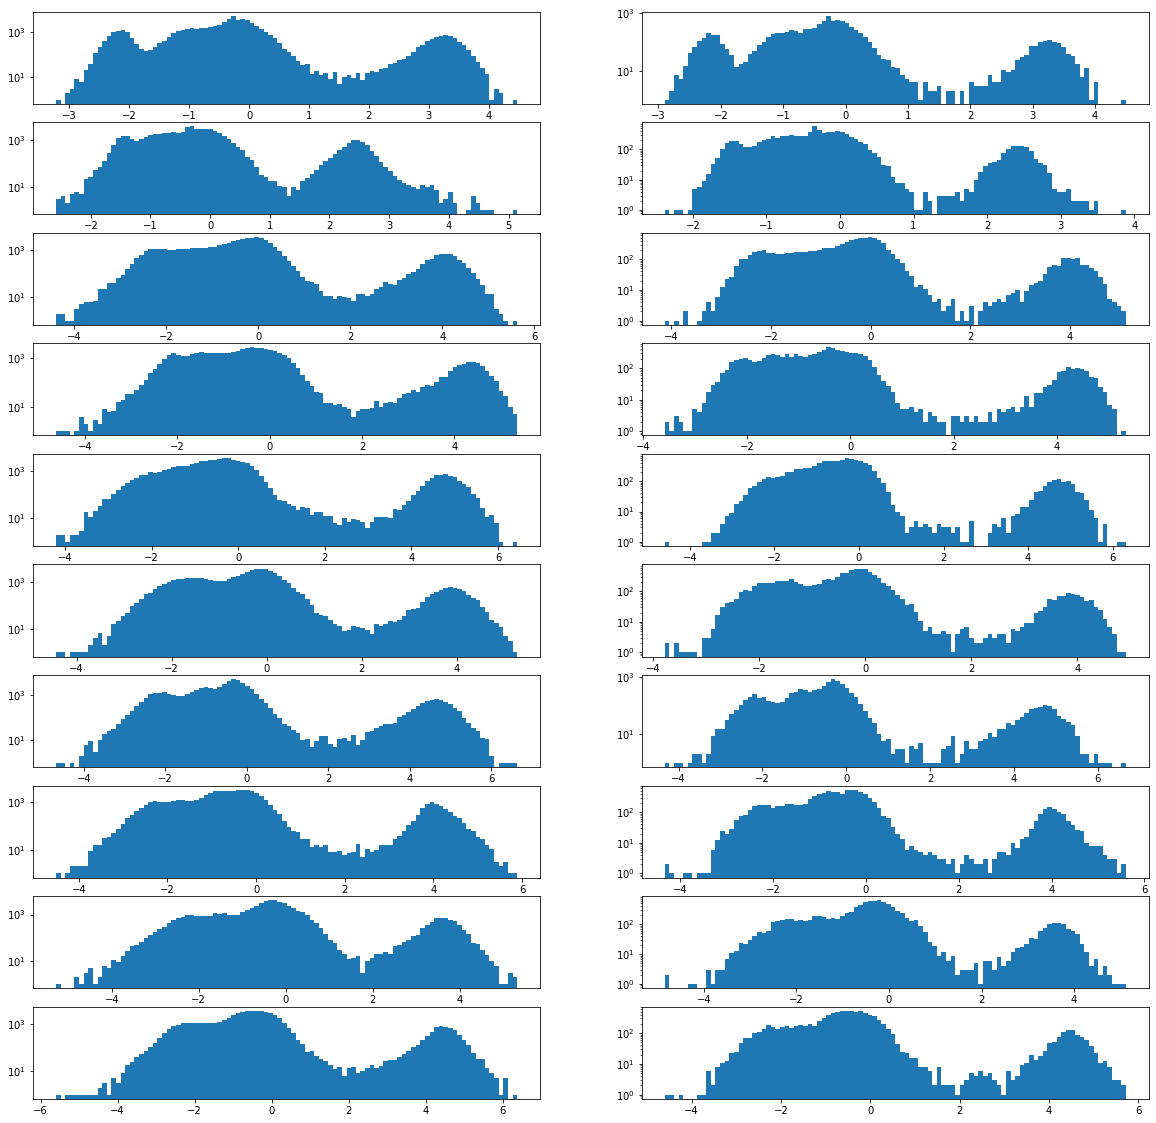

In [9]:
result_train=model.predict(ds_train)
result_test = model.predict(ds_test)
draw_result_hist()

观察上图可以发现：
 预测值分成了两类，一类集中在几率为1附件(logit=4-6)，另一类集中在几率为0.5附件(logit=-2,2)。
 这个结果该如何解释?
 


统计数据通道的预测结果的直方图
ie,对于值为n的图片，只统计预测通道n.




In [10]:
result_split=[]
for i in range(10):
    ds_train_i = ds_train_orig.filter(lambda x:tf.reshape(tf.math.equal(x['label'],i),[]))
    result_split.append(model.predict(opt_data(ds_train_i,shuffle=False)))

In [11]:
def draw_result_max(result):
    plt.figure(figsize=(20,20))
    for i in range(10):
        plt.subplot(10,1,i+1)
        plt.hist(result[i][:,i],bins=100,log=True)

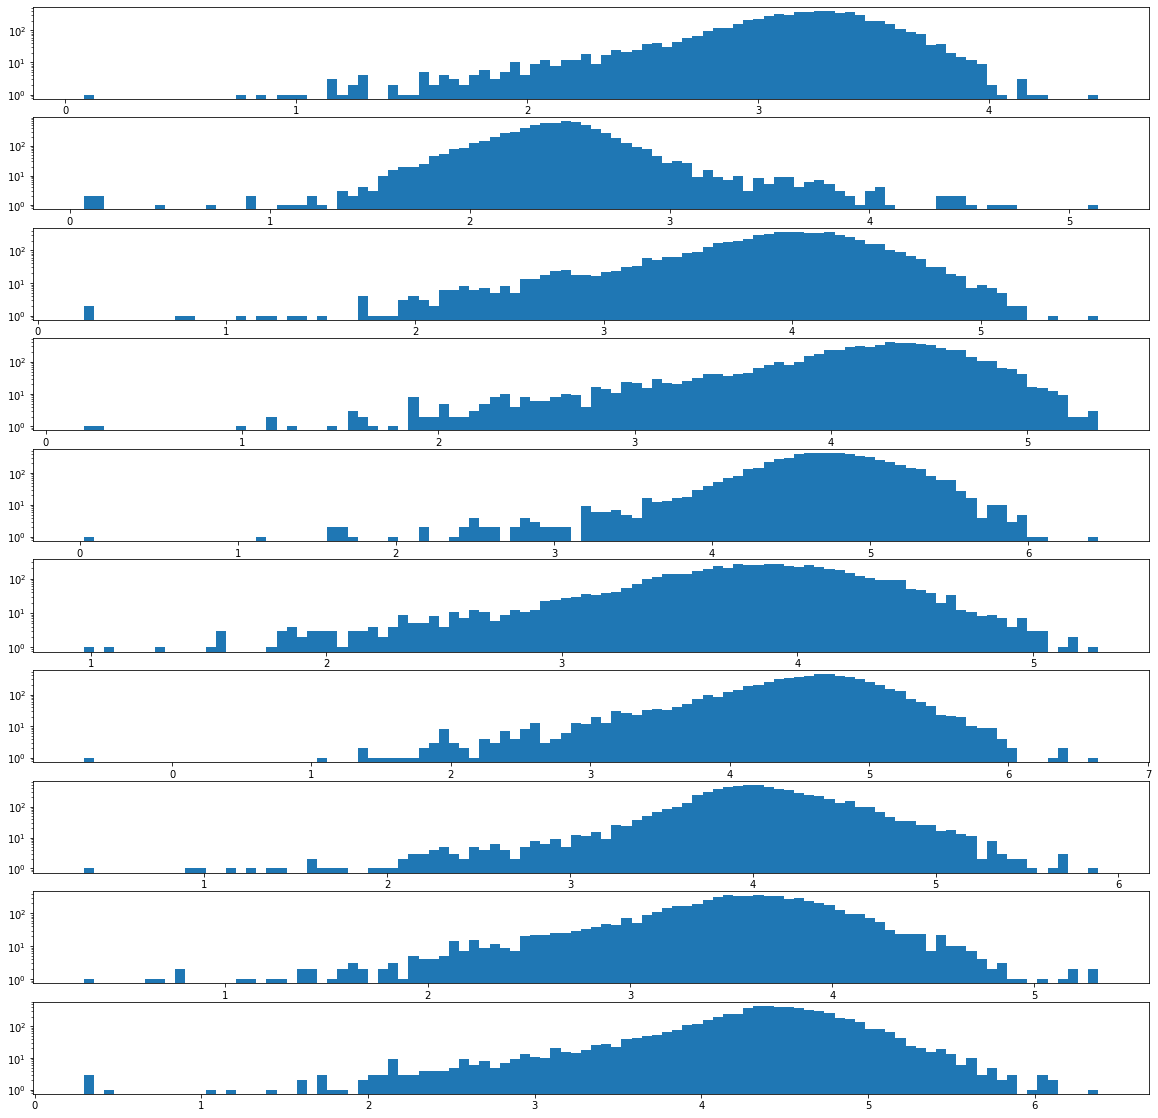

In [12]:
draw_result_max(result_split)

计算正确通道的平均值和方差.
 使用 label_smoothing时,从上图可以看出,直方图的分布比较集中。方差也比较小。
如果不使用label_smoothing时，将会向大小两个方向发散开来。因为几率是用sigmoid计算，数值要为正负无穷大才会接近1,0.





In [ ]:
pred_mean=np.zeros(10,np.float32)
pred_std=np.zeros(10,np.float32)
for i in range(10):
    m=np.mean(result_split[i][:,i])
  
    delta=np.std(result_split[i][:,i])
    pred_mean[i]=m
    pred_std[i]=delta
    print(i,m,delta)
print(np.sum(pred_std))    

0 4.497176 0.4272443
1 4.035005 0.39862934
2 5.536211 0.5193586
3 4.6711154 0.39701322
4 4.6287336 0.4784579
5 4.5472374 0.46031612
6 4.417082 0.4374387
7 5.2105913 0.648319
8 4.511776 0.5121153
9 4.496439 0.5079458
4.7868385


In [ ]:
#iter=ds_train.as_numpy_iterator()
#picBase=iter.next()[0][14]

#open("./img/data2.jpg","xb").write(
#   tf.image.encode_jpeg(tf.image.convert_image_dtype(picBase,dtype=tf.uint8)).numpy())


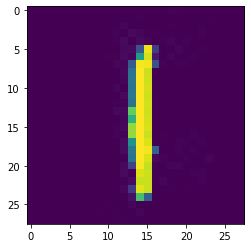

In [ ]:

picBase = tf.image.convert_image_dtype(tf.image.decode_jpeg(open("./img/data1.jpg","rb").read()),dtype=tf.float32).numpy()
plt.imshow(picBase)

虽然预测值不是高斯分布，还是使用高斯分布来近似模拟。
根据高斯函数的性质，
  95.449974%的面積在平均數左右兩個標準差的範圍內。
  99.730020%的面積在平均數左右三個標準差的範圍內。
  99.993666%的面積在平均數左右四個標準差的範圍內

如果预测值偏离平均值3个标准差以上，就可以认为是异常数据。
或者说，是模型不能模拟的数据。

通过旋转一个数字来验证。


In [ ]:
def gause(x,mu,delta):
    return np.exp( - 0.5* (x-mu)**2/delta**2) / delta /np.sqrt(2*np.pi)
#plt.plot(gause(np.linspace(-3,3),0,1))
#plt.grid()  

In [ ]:
def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x,deg,reshape=False).ravel()
  
def gen_rotate_imgs(img,N_ANGLES=30):
    imgs=np.zeros((N_ANGLES,28,28,1))
    for i in range(N_ANGLES):
        imgs[i,:,:,:]=rotate_img(picBase,360/N_ANGLES*i).reshape(28,28,1)  
    return imgs

In [ ]:
def draw_rotated_imgs(imgs,N_ANGLES=30):
    plt.figure(figsize=(20,2))
    for i in range(N_ANGLES):
        plt.subplot(1,N_ANGLES,i+1)
        plt.imshow(imgs[i,:,:])
        plt.axis('off')

In [ ]:
def analyze_rotated_imgs(pred):
    plt.figure(figsize=(30,20))
    pltlines=plt.plot(tf.math.sigmoid(pred))
    plt.legend(['0','1','2','3','4','5','6','7','8','9'])

    indexes=np.argmax(pred,axis=1)
    #print(indexes)
    maximum_values = pred[np.arange(pred.shape[0]), indexes]
    #print(np.array(list(range(len(indexes)))))
    print('pred:',indexes)
    print('pred logit:',maximum_values)
    print('pred sum prob:',tf.math.reduce_sum(tf.math.sigmoid(pred),axis=1).numpy())
    plt.figure()
    plt.plot(maximum_values)
    plt.grid()
    plt.figure()
    #plt.title('准确度')
    #plt.plot(np.log(gause(maximum_values,pred_mean[indexes],pred_std[indexes])))
    print('pred to mean',np.abs(maximum_values-pred_mean[indexes])/pred_std[indexes])
    g=gause(maximum_values,pred_mean[indexes],pred_std[indexes])
    #print(g)
    plt.plot(g)
    plt.grid()

In [ ]:
imgs = gen_rotate_imgs(picBase)

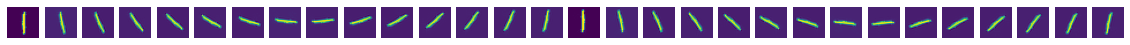

In [ ]:
draw_rotated_imgs(imgs)

pred: [1 1 1 1 2 2 2 7 7 5 5 1 1 1 1 1 1 1 1 2 2 2 4 4 2 2 1 1 1 1]
pred logit: [4.0578403 4.5186534 4.6022716 1.7453543 3.4601736 3.6028192 2.6910532
 2.328291  4.3657165 2.7882752 2.1632903 3.7051964 3.4960027 3.3474808
 4.293819  4.0096574 4.856574  5.221675  2.3909822 2.7914007 3.9926863
 3.6110947 5.147409  4.073914  2.259087  3.3909795 4.4456005 4.166046
 3.7458615 3.8231258]
pred sum prob: [4.4962564 5.063843  5.6720343 6.6572523 6.0798774 6.190098  6.101431
 5.0588427 4.201243  5.351015  4.0737457 4.3665752 4.6228747 4.8228164
 4.223242  4.0711913 4.641476  5.7686825 6.1555967 6.0688677 6.2220254
 6.565687  4.163143  4.752285  5.134933  5.8297324 5.9504185 5.2767534
 4.168746  4.200881 ]
pred to mean [0.05728443 1.2132783  1.4230424  5.743809   3.9973104  3.7226532
 5.4782147  4.4458055  1.3031777  3.8212047  5.1789346  0.8273569
 1.3521394  1.7247208  0.64925945 0.06358717 2.0609846  2.9768753
 4.1241894  5.2850003  2.9719827  3.706719   1.0840564  1.1595995
 6.3099446  4.1305

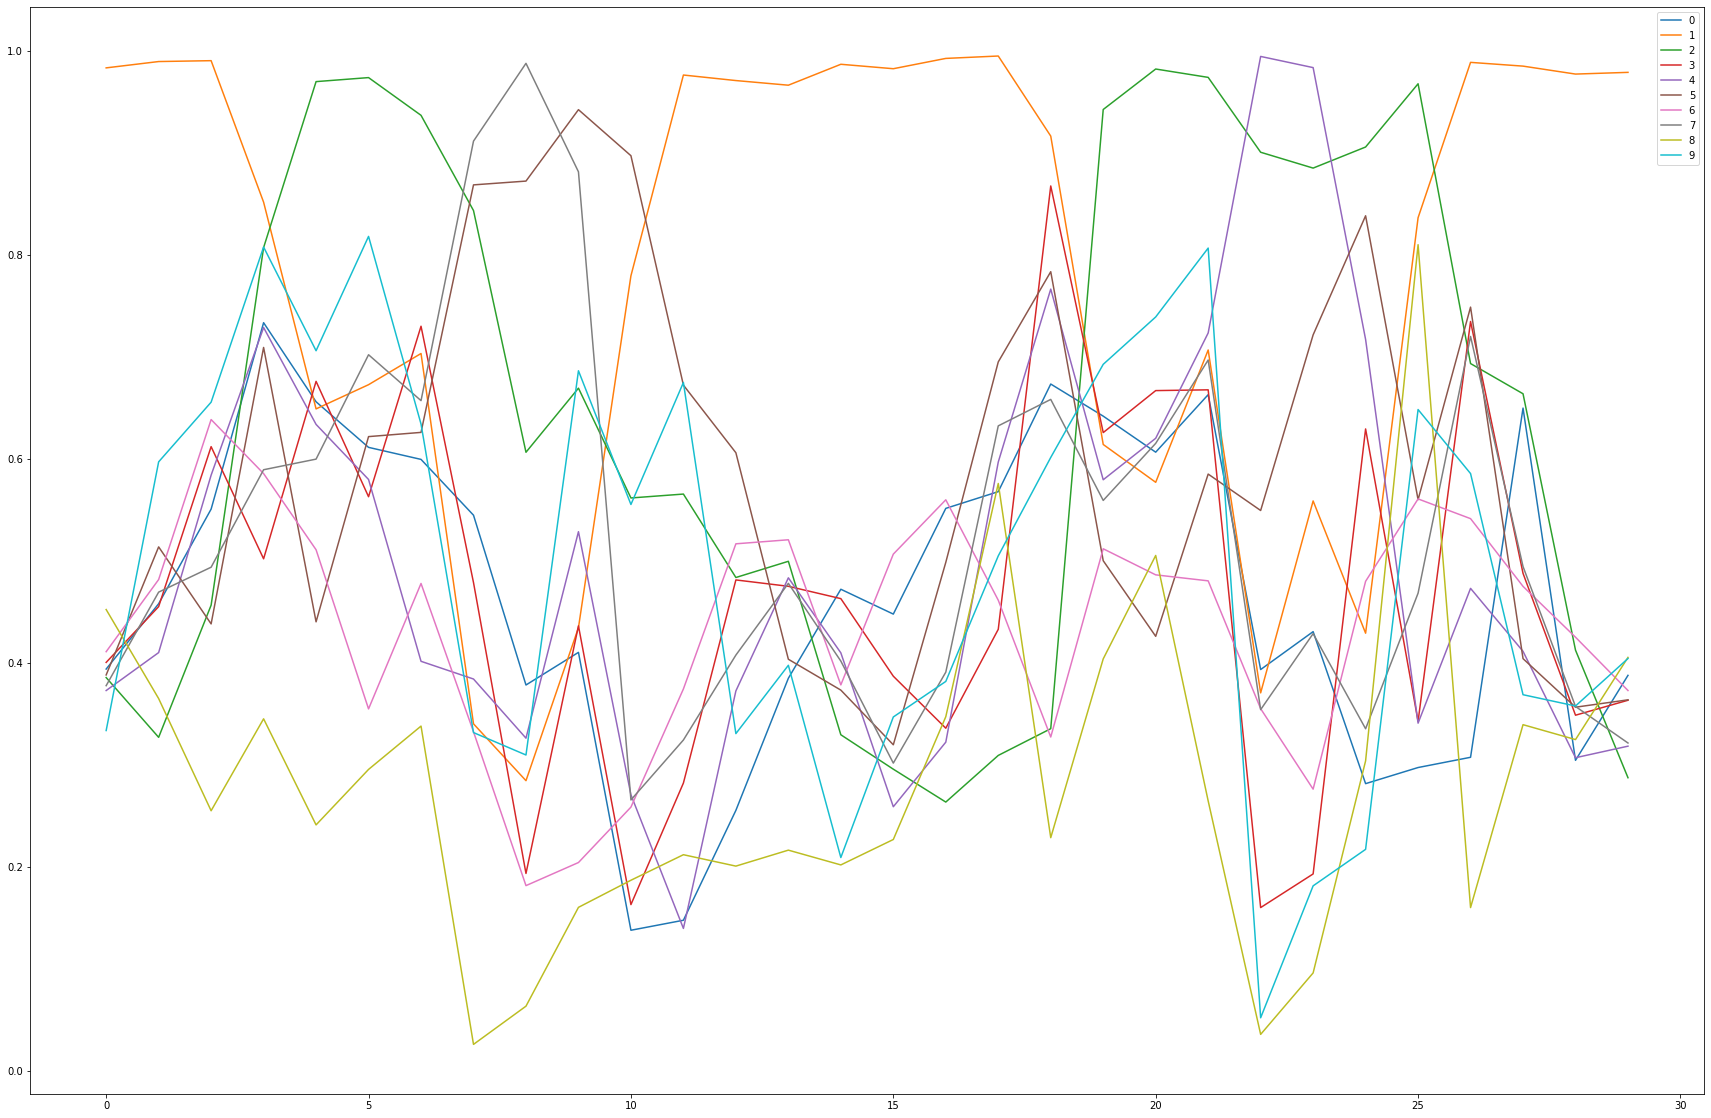

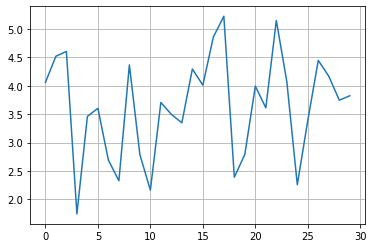

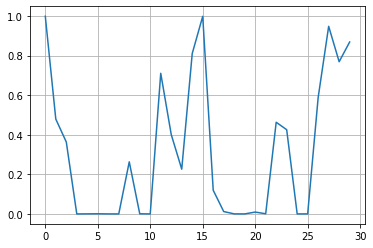

In [ ]:
analyze_rotated_imgs(model.predict(imgs))

分析上边的结果可以看到。
随着旋转角度的改变，模型可能给出错误的预测结果。
对于数字1：

pred: [1 1 1 1 2 2 2 7 7 5 5 1 1 1 1 1 1 1 1 2 2 2 4 4 2 2 1 1 1 1]

pred logit: [4.0578403 4.5186534 4.6022716 1.7453543 3.4601736 3.6028192 2.6910532
 2.328291  4.3657165 2.7882752 2.1632903 3.7051964 3.4960027 3.3474808
 4.293819  4.0096574 4.856574  5.221675  2.3909822 2.7914007 3.9926863
 3.6110947 5.147409  4.073914  2.259087  3.3909795 4.4456005 4.166046
 3.7458615 3.8231258]
 
pred sum prob: [4.4962564 5.063843  5.6720343 6.6572523 6.0798774 6.190098  6.101431
 5.0588427 4.201243  5.351015  4.0737457 4.3665752 4.6228747 4.8228164
 4.223242  4.0711913 4.641476  5.7686825 6.1555967 6.0688677 6.2220254
 6.565687  4.163143  4.752285  5.134933  5.8297324 5.9504185 5.2767534
 4.168746  4.200881 ]
 
把所有的置信度相加，最终结果并不等于1. 
 
pred to mean [0.05728443 1.2132783  1.4230424  5.743809   3.9973104  3.7226532
 5.4782147  4.4458055  1.3031777  3.8212047  5.1789346  0.8273569
 1.3521394  1.7247208  0.64925945 0.06358717 2.0609846  2.9768753
 4.1241894  5.2850003  2.9719827  3.706719   1.0840564  1.1595995
 6.3099446  4.1305404  1.0300181  0.32872906 0.7253444  0.5315195 ]

可以看到偏离均值的程度基本可以用来判定模型可能预测错误。
但是中间一些结果在一个标准差范围内，实际结果却不正确。


使用完全无关的图片进行验证

In [ ]:
YODA_PATH='./img/yoda.jpg'
picYoda=tf.io.decode_image( open(YODA_PATH,'rb').read())
picYoda= tf.image.convert_image_dtype(picYoda,dtype=tf.float32)
picYoda = tf.image.resize(picYoda,(28,28))
picYoda = tf.image.rgb_to_grayscale(picYoda)

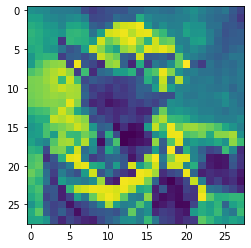

In [ ]:
plt.imshow(picYoda)

In [ ]:
resultYoda = model(tf.expand_dims(picYoda,0))[0]

In [ ]:
print(resultYoda)

tf.Tensor(
[-0.61985165 -0.6221639   1.2571585   0.79358006 -0.74815     1.8634355
 -0.46505222 -0.9145503  -1.265624   -1.2769855 ], shape=(10,), dtype=float32)


In [ ]:
def calc_u(result):
    index=np.argmax(result)
    return gause(result[index],pred_mean[index],pred_std[index])

In [ ]:
calc_u(resultYoda)

3.6006779265367884e-08